# ART calculations for `Marburg` virus

In [1]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
/usr/local/art/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.
Exception ign

In [2]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [3]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/Marburg'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Marburg` into a data frame with `duplicate` SMILES

In [4]:
MarburgVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_wMACAW.csv")
MarburgVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL5593581,CN(C)C1CCN(C(=O)c2cc3ccccc3n2Cc2cccnc2)CC1,4.413413,Marburg,-0.122310,0.274089,-0.040032,0.139557,-0.005811,0.137682,-0.243678,0.134492,-0.110119,0.058980,-0.084873,0.048180,0.011416,0.005596,-0.028332
1,2,CHEMBL5593153,CN(C)C1CCN(C(=O)c2cc3occc3n2Cc2ccc(Cl)cc2)CC1,5.099087,Marburg,-0.137225,0.327071,-0.027621,0.186855,0.045965,0.116218,-0.217885,0.164366,0.031558,0.057860,-0.041662,-0.097074,-0.011885,-0.060431,0.087327
2,4,CHEMBL5593168,CC(C)N1CCN(C(=O)c2cc3sccc3n2Cc2ccc(Cl)cc2)CC1,4.484126,Marburg,-0.119712,0.273791,-0.030392,0.157136,0.033473,0.061013,-0.198762,0.111817,0.070672,0.077171,0.043873,-0.158405,-0.014840,-0.068132,0.057103
3,5,CHEMBL1236524,Nc1ncnc2c([C@@H]3N[C@H](CO)[C@@H](O)[C@H]3O)c[...,5.522879,Marburg,0.009413,0.020522,0.035893,-0.354140,0.070985,0.177179,-0.039038,0.012065,-0.006665,-0.001787,-0.016705,-0.126759,0.039604,0.239508,-0.063676
4,6,CHEMBL5592994,CCN1CCN(CC(=O)O[C@H]2C(C)(C)[C@H]3CC[C@]2(C)C3...,4.521434,Marburg,0.393294,0.006360,-0.073046,-0.014516,0.021267,-0.091542,-0.018768,0.143587,-0.068154,-0.089638,0.162075,0.072658,-0.163295,0.058076,0.009248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,199,CHEMBL5595280,C[C@@H]1[C@H]2C[C@@H](C[C@H]1OC(=O)CN1CCCCC1)C...,3.970616,Marburg,0.379132,-0.022542,-0.018380,-0.017197,-0.105484,0.182141,0.030699,-0.187773,0.068991,0.129476,0.034749,-0.072859,-0.142748,-0.094073,0.021018
182,200,CHEMBL5592622,C[C@@H]1[C@H]2C[C@@H](C[C@H]1OC(=O)CN1CCN(C)CC...,4.322393,Marburg,0.359035,-0.013220,-0.031952,-0.013236,-0.092083,0.210590,0.035485,-0.174532,0.045830,0.125757,0.071039,-0.064833,-0.151279,-0.089996,0.038304
183,201,CHEMBL1655,CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1,6.154902,Marburg,-0.164455,-0.044803,-0.091422,-0.094592,-0.399383,0.008630,0.104971,0.066738,-0.142540,-0.051001,-0.033169,0.081863,0.022697,-0.043963,0.191893
184,202,CHEMBL5590446,CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1OC(=O)CCCN1CCCCC1,5.337242,Marburg,0.426381,-0.034964,-0.080330,0.013305,0.032448,-0.161463,0.037231,0.055118,-0.005967,-0.076068,-0.206127,-0.051343,0.181551,-0.020008,-0.036805


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [5]:
input_var = [col for col in MarburgVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [6]:
features = MarburgVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [7]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [8]:
response = MarburgVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [9]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'MarburgVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [10]:
MarburgVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_wMACAW_ARTready.csv")
MarburgVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.122310
1,1,MACAW_1,-0.137225
2,2,MACAW_1,-0.119712
3,3,MACAW_1,0.009413
4,4,MACAW_1,0.393294
...,...,...,...
2971,181,pPotency,3.970616
2972,182,pPotency,4.322393
2973,183,pPotency,6.154902
2974,184,pPotency,5.337242


### Define the ART parameters needed for the prediction

In [11]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 186 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_regressor
is_classifier
is_regressor
is_

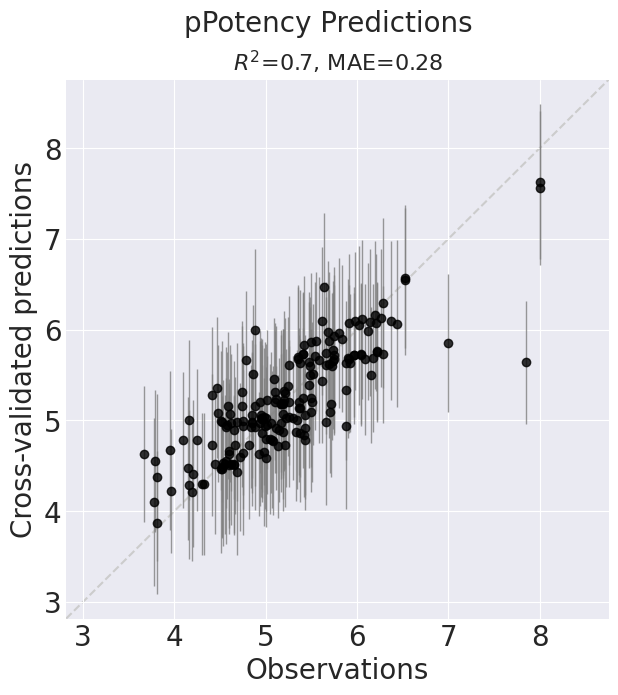

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

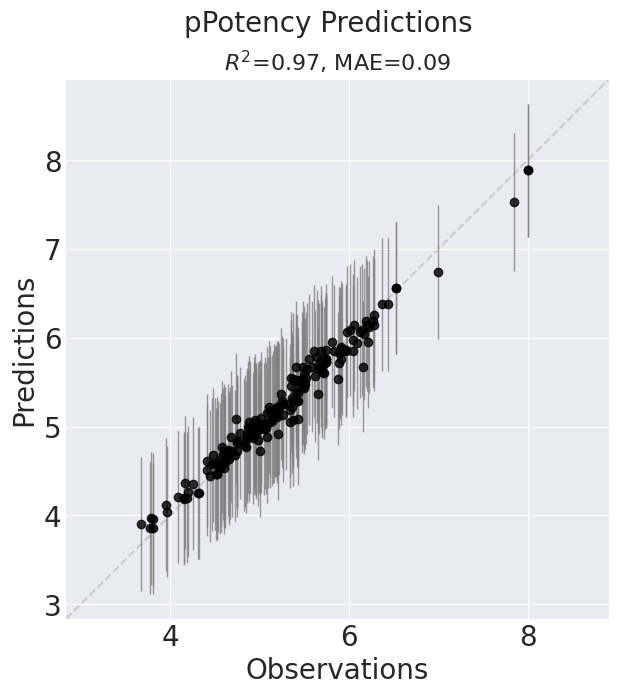

CPU times: user 7min 29s, sys: 7.8 s, total: 7min 37s
Wall time: 1h 26min 29s


In [12]:
%%time

art = RecommendationEngine(df=MarburgVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [28]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/Marburg/art.cpkl


### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [13]:
MarburgVirus_EnamineDatasets_wMACAW = pd.read_csv(resultsDir + "Marburg/Marburg_EnamineDataset_wMACAW.csv")
MarburgVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,0.061590,0.025312,-0.031838,-0.164235,0.047803,0.049884,0.031639,-0.023425,-0.015294,-0.012352,-0.007832,-0.027858,-0.002736,-0.039039,-0.007636
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,0.011383,0.074644,0.017088,-0.111969,0.053477,-0.014637,0.025688,-0.015291,0.021558,0.019359,0.014460,0.001090,0.038610,-0.034128,-0.008571
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,0.039651,0.030710,0.019267,-0.051107,0.003287,0.025492,0.020353,-0.025619,-0.048674,0.040311,-0.009305,0.029726,-0.000411,-0.035475,-0.058065
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,0.097860,0.023345,0.015204,-0.068243,0.049138,-0.008216,0.047623,-0.021061,0.029175,0.000247,-0.043843,-0.028854,0.019433,-0.027016,-0.023692
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,0.013763,0.067897,-0.028065,-0.031729,0.023279,-0.055835,0.032686,-0.059242,-0.009203,0.000708,-0.007347,0.012186,0.028046,0.027110,-0.029747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,0.027869,-0.008501,0.070138,-0.075288,0.020678,0.026926,0.050160,-0.006819,0.004060,0.005103,-0.037911,-0.014699,0.011811,-0.042698,-0.037276
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,-0.004430,0.051379,0.005776,-0.174583,0.012799,0.045863,-0.030342,-0.025879,-0.022156,-0.044597,0.053848,-0.048093,0.056967,0.008217,0.012129
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,0.087340,0.047623,0.032081,-0.082581,0.042935,0.039188,-0.011444,-0.004882,-0.027284,0.004456,-0.018203,-0.010370,-0.035214,-0.040627,0.003021
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,0.028761,0.009142,0.071553,-0.080056,0.018707,0.019494,-0.013342,-0.025657,-0.010789,0.014078,-0.029623,-0.018191,0.011496,0.027631,-0.016206


In [14]:
macaw_columns = [col for col in MarburgVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = MarburgVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [15]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

array([[5.10421992],
       [4.84293353],
       [4.80855144],
       ...,
       [4.926013  ],
       [4.99224451],
       [4.84982696]])

Get predictions with uncertainty using ART's post_pred_stats

In [16]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = MarburgVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,5.104220,0.378755,4.361860,5.846579,0.000008,0.000001,0.000043
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,4.842934,0.382449,4.093333,5.592534,0.000014,0.000003,0.000081
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,4.808551,0.385995,4.052001,5.565102,0.000016,0.000003,0.000089
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,5.044483,0.380149,4.299391,5.789575,0.000009,0.000002,0.000050
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,4.729099,0.381312,3.981728,5.476470,0.000019,0.000003,0.000104
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,4.982636,0.383738,4.230510,5.734761,0.000010,0.000002,0.000059
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,5.194898,0.380325,4.449460,5.940336,0.000006,0.000001,0.000036
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,4.926013,0.388285,4.164975,5.687051,0.000012,0.000002,0.000068
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,4.992245,0.385084,4.237479,5.747010,0.000010,0.000002,0.000058


## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [17]:
MarburgVirus_LCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Marburg/Marburg_LCAntiviralsData_wMACAW.csv")
MarburgVirus_LCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,0.032686,0.044811,0.169198,-0.071430,-0.014344,-0.039406,0.000155,-0.032717,0.019993,0.004014,-0.012514,0.013327,0.031209,0.012031,-0.020254
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,0.045095,0.056484,0.035155,-0.128754,0.054231,-0.036430,-0.021909,-0.014157,-0.069317,0.033454,-0.013847,-0.026355,0.014018,0.041500,0.035081
2,CN1CCCN(Cc2ccncc2)CC1,0.049468,0.056257,0.041178,-0.099769,-0.017885,0.011476,-0.013423,-0.000826,-0.042817,0.050225,0.010983,-0.001343,-0.009697,-0.000426,-0.022336
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,0.082395,0.028197,0.027792,-0.110597,0.028677,0.015821,-0.041643,-0.000367,-0.047593,0.038659,0.025182,-0.035591,-0.017483,0.006717,0.009741
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,0.053032,0.040188,0.100522,-0.139422,0.015821,0.014781,0.001545,-0.013264,-0.023844,0.023740,-0.021202,0.002331,-0.018129,0.000171,-0.003059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,-0.138680,0.025984,-0.074797,-0.086349,-0.098554,0.034413,0.043382,-0.009169,-0.142911,-0.042257,0.016458,0.025236,0.031976,-0.012657,-0.020424
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,-0.088899,0.025440,-0.040315,-0.063808,-0.063249,0.001594,0.046820,-0.036915,-0.100096,-0.006767,0.014349,0.016781,-0.005824,-0.015455,0.017186
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,-0.071096,0.030739,-0.070588,-0.160110,-0.005354,0.007308,-0.021245,-0.042384,-0.021863,-0.008875,0.040390,-0.024150,0.019910,-0.032733,0.031434
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,-0.112554,-0.034219,-0.026810,-0.005253,0.096964,0.032540,0.004506,-0.045998,-0.056574,-0.048538,0.056730,0.011658,0.031694,-0.049494,0.030286


In [18]:
macaw_columns = [col for col in MarburgVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = MarburgVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [19]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

array([[4.67588291],
       [5.023654  ],
       [4.81533035],
       ...,
       [5.06552804],
       [5.33435845],
       [5.58364825]])

Get predictions with uncertainty using ART's post_pred_stats

In [20]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = MarburgVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,4.675883,0.381409,3.928322,5.423444,0.000021,3.771862e-06,0.000118
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,5.023654,0.380064,4.278729,5.768579,0.000009,1.703811e-06,0.000053
2,CN1CCCN(Cc2ccncc2)CC1,4.815330,0.386310,4.058162,5.572499,0.000015,2.676095e-06,0.000087
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,5.038431,0.384988,4.283854,5.793008,0.000009,1.610617e-06,0.000052
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,4.883386,0.383293,4.132132,5.634640,0.000013,2.319314e-06,0.000074
...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,5.179245,0.390766,4.413343,5.945147,0.000007,1.134626e-06,0.000039
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,5.013619,0.386992,4.255114,5.772124,0.000010,1.689959e-06,0.000056
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,5.065528,0.380498,4.319751,5.811305,0.000009,1.544171e-06,0.000048
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,5.334358,0.386473,4.576871,6.091846,0.000005,8.093823e-07,0.000026


## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [21]:
MarburgVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Marburg/Marburg_ChemDivAntiviralsData_wMACAW.csv")
MarburgVirus_ChemDivAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,-0.060902,-0.000621,-0.033123,-0.021463,0.020854,0.058710,-0.017326,-0.089679,-0.061065,-0.026789,0.019574,0.010507,0.038854,-0.052864,-0.050329
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,0.001287,0.040540,0.034152,-0.016171,0.066411,0.029587,-0.023923,-0.036369,-0.032405,0.004905,-0.029190,-0.015591,0.019325,-0.032166,-0.010194
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,-0.052615,0.017919,-0.013998,-0.013964,0.022852,0.068534,-0.055932,-0.099554,-0.059904,-0.042644,0.043814,0.037050,0.032088,-0.051776,-0.025179
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,-0.094969,0.016926,-0.034670,-0.090463,0.089397,-0.024895,0.015878,-0.088203,-0.044624,-0.018056,0.018469,-0.039177,-0.019319,-0.064439,-0.048902
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,-0.104150,-0.014379,0.038260,0.013952,0.055148,-0.002669,-0.011354,-0.012171,-0.063661,0.012884,0.007102,-0.033789,-0.021747,-0.049013,-0.058690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64953,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,-0.061765,-0.047829,-0.005426,-0.051550,0.145981,0.022473,-0.028851,-0.067369,-0.102134,-0.066848,-0.009258,-0.052934,-0.027302,-0.086544,0.055622
64954,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,-0.079206,-0.050934,-0.022289,-0.064215,0.146002,0.005857,-0.020032,-0.077947,-0.093527,-0.063798,-0.026248,-0.053943,-0.032647,-0.066660,0.026779
64955,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,-0.055132,-0.051340,-0.004941,-0.076618,0.127388,0.008714,-0.038033,-0.060649,-0.094588,-0.053444,-0.010270,-0.053380,-0.038579,-0.076867,0.027729
64956,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,-0.058300,-0.000775,-0.045382,-0.092140,0.124563,0.062383,-0.012179,-0.063298,-0.127972,-0.086545,0.013991,-0.041154,-0.021020,-0.096045,0.061589


In [22]:
macaw_columns = [col for col in MarburgVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = MarburgVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [23]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.50734382],
       [4.9395558 ],
       [5.27112165],
       ...,
       [5.6936481 ],
       [5.90524876],
       [5.92433838]])

Get predictions with uncertainty using ART's post_pred_stats

In [24]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = MarburgVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,5.507344,0.398168,4.726934,6.287753,0.000003,5.155212e-07,0.000019
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,4.939556,0.387140,4.180760,5.698351,0.000011,2.002852e-06,0.000066
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,5.271122,0.384785,4.516942,6.025301,0.000005,9.434066e-07,0.000030
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,5.306134,0.381664,4.558072,6.054195,0.000005,8.826836e-07,0.000028
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,5.087838,0.391140,4.321204,5.854472,0.000008,1.398068e-06,0.000048
...,...,...,...,...,...,...,...,...
64953,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,5.735003,0.408750,4.933853,6.536154,0.000002,2.909688e-07,0.000012
64954,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,5.695240,0.407345,4.896843,6.493637,0.000002,3.208952e-07,0.000013
64955,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,5.693648,0.405403,4.899059,6.488237,0.000002,3.249097e-07,0.000013
64956,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,5.905249,0.389505,5.141819,6.668678,0.000001,2.144480e-07,0.000007


### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [25]:
MarburgVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Marburg/Marburg_SMACCAntiviralsData_wMACAW.csv")
MarburgVirus_SMACCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,-0.028845,0.050143,-0.011724,-0.178137,0.073362,0.046463,0.013216,-0.038083,-0.058571,-0.014944,-0.007818,-0.008222,0.027079,-0.018039,-0.013272
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,-0.099356,-0.022321,-0.031060,-0.132252,0.031697,0.012234,0.010163,-0.063105,-0.039612,-0.056324,0.013676,0.035731,-0.001905,-0.068323,-0.022270
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,-0.017470,0.051571,-0.016019,-0.164822,0.064938,0.020529,-0.049656,-0.028832,-0.026295,-0.001683,-0.004657,0.005027,-0.016335,-0.033938,0.015813
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,0.003199,0.049035,-0.031034,-0.235879,0.018218,-0.005311,-0.006992,0.017275,0.004454,0.068834,0.036714,0.035057,0.038545,-0.024814,0.010603
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,-0.067079,0.013964,-0.024434,-0.110878,0.091201,0.033503,0.018830,-0.049199,-0.047285,-0.029799,0.050264,0.012901,0.021177,-0.040064,-0.013878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,0.003703,0.025448,-0.010073,-0.247776,0.037953,0.035974,-0.022145,-0.017885,-0.013177,0.013167,-0.017213,0.005166,-0.022852,-0.034690,-0.013748
1608,S=C1Nc2ccccc2S1,0.012891,0.029537,-0.003350,-0.240029,0.029732,0.027777,-0.040031,-0.006902,0.009037,0.030361,-0.003286,0.029582,0.006872,-0.032111,0.005187
1609,SC(=S)N1CCCC1,0.076631,0.007505,-0.005292,-0.152849,0.019793,-0.008064,-0.020699,-0.003003,0.001922,0.016119,0.015798,-0.013355,-0.006723,-0.007879,0.030161
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,-0.045134,0.063038,-0.057493,-0.244231,-0.004326,-0.008529,-0.020925,-0.007836,-0.004862,0.010194,-0.020044,0.018065,-0.024578,-0.012169,0.032541


In [26]:
macaw_columns = [col for col in MarburgVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = MarburgVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [27]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.22723556],
       [5.51657056],
       [5.09380232],
       ...,
       [5.01617481],
       [5.04133571],
       [5.07787038]])

Get predictions with uncertainty using ART's post_pred_stats

In [28]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = MarburgVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,5.227236,0.380267,4.481913,5.972558,0.000006,1.065226e-06,0.000033
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,5.516571,0.393938,4.744452,6.288689,0.000003,5.144119e-07,0.000018
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,5.093802,0.382453,4.344194,5.843410,0.000008,1.434134e-06,0.000045
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,4.902661,0.380925,4.156049,5.649274,0.000013,2.242466e-06,0.000070
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,5.302586,0.381895,4.554072,6.051100,0.000005,8.889957e-07,0.000028
...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,5.196402,0.382435,4.446828,5.945975,0.000006,1.132466e-06,0.000036
1608,S=C1Nc2ccccc2S1,5.018214,0.382315,4.268877,5.767551,0.000010,1.707846e-06,0.000054
1609,SC(=S)N1CCCC1,5.016175,0.380793,4.269821,5.762528,0.000010,1.727714e-06,0.000054
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,5.041336,0.384290,4.288128,5.794544,0.000009,1.604930e-06,0.000052


### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [29]:
MarburgVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(resultsDir + "Marburg/Marburg_DTRA_smiles_wMACAW.csv")
MarburgVirus_DTRA_target_antivirals_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,-0.024037,-0.074834,0.000482,-0.065594,0.174935,0.101367,-0.015720,-0.116696,-0.099138,-0.133660,0.094974,0.017479,0.080616,-0.032387,0.142323
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,0.023943,0.002860,0.040341,-0.163332,0.069085,0.096659,-0.041604,-0.071575,-0.039420,-0.034799,0.034852,-0.024525,0.054313,0.053077,0.029379


In [30]:
macaw_columns = [col for col in MarburgVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = MarburgVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [31]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

array([[6.61248924],
       [5.41285372]])

Get predictions with uncertainty using ART's post_pred_stats

In [32]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = MarburgVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Marburg/MarburgVirus_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,6.612489,0.387524,5.852942,7.372037,2.440680e-07,4.245834e-08,0.000001
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,5.412854,0.380337,4.667393,6.158315,3.864971e-06,6.945211e-07,0.000022


### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [33]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

,Smiles,VirusClassifier,pPotency
0,C#CN(CCCC1(C)N=N1)C(=O)[C@]12CCC(C)(C)C[C@H]1C...,Ebola,6.330404
1,C#C[C@@]1(c2ccc3c(N)ncnn23)O[C@H](COP(=O)(N[C@...,Ebola,5.408935
2,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,Ebola,4.889410
3,C1=C2CCCN(Cc3ccccc3)[C@H]2[C@@H]2C[C@H]1[C@H]1...,Ebola,4.818156
4,C1=C2CCCN[C@H]2[C@@H]2C[C@H]1[C@H]1CCCCN1C2,Ebola,4.906578
...,...,...,...
451,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)C2...,Ebola,6.907342
452,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)CC...,Ebola,6.191151
453,[2H]C([2H])(c1cc(Cl)ccc1NCc1ccc(S(C)(=O)=O)cc1...,Ebola,7.320177
454,c1cc(NCCCCN2CCOCC2)c2nccc(NCCCCN3CCOCC3)c2n1,Ebola,5.327058


### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES